# Credit Card Fraud Detection Using Machine Learning

**Authors:** Lili Ke, Noah Foilb  
**Course:** CS 6220 Data Mining  

---

## Project Overview

Credit card fraud represents a significant challenge in the financial industry. This project develops and compares multiple machine learning approaches for detecting fraudulent transactions.

In [1]:
# Import all required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
import sklearn
warnings.filterwarnings('ignore')

# Machine Learning Libraries
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    precision_recall_curve, roc_curve, auc, f1_score, accuracy_score,
    precision_score, recall_score
)
from sklearn.utils import class_weight

# ML Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.neural_network import MLPRegressor

# Imbalanced Learning
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Interpretability
import shap
from sklearn.inspection import permutation_importance

# Visualization
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# Set style and random seeds for reproducibility
plt.style.use('seaborn-v0_8')
np.random.seed(42)
tf.random.set_seed(42)

# 1. Data Loading and Initial Exploration

In this section, we load the Credit Card Fraud Detection dataset and perform initial exploration.

In [2]:
df = pd.read_csv('creditcard.csv')

print(f"Dataset shape: {df.shape}")

Dataset shape: (284807, 31)


In [3]:
# Dataset Overview
print(f"Length: {len(df):,}")
print(f"Number of features: {df.shape[1]}")

# Display first few rows
print("\nFirst 5 rows:")
display(df.head())

# Basic statistics
print(f"\Stats:")
display(df.describe())

# Calculate class distribution
class_counts = df['Class'].value_counts()
class_percentages = df['Class'].value_counts(normalize=True) * 100

print(f"\nLegitimate transactions (Class 0): {class_counts[0]:,} ({class_percentages[0]:.3f}%)")
print(f"Fraudulent transactions (Class 1): {class_counts[1]:,} ({class_percentages[1]:.3f}%)")
print(f"Imbalance ratio: {class_counts[0] / class_counts[1]:.1f}:1")

Length: 284,807
Number of features: 31

First 5 rows:


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


\Stats:


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000



Legitimate transactions (Class 0): 284,315 (99.827%)
Fraudulent transactions (Class 1): 492 (0.173%)
Imbalance ratio: 577.9:1


In [4]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [5]:
# Convert time to hours for better interpretation
df['Hour'] = (df['Time'] / 3600) % 24  

# 2. Exploratory Data Analysis (EDA)



In [6]:
# Amount statistics by class
amount_stats = df.groupby('Class')['Amount'].describe()
print("Amount Statistics by Class:")
display(amount_stats)

print(f"\n• Legitimate transactions: Mean = €{amount_stats.loc[0, 'mean']:.2f}, Std = €{amount_stats.loc[0, 'std']:.2f}")
print(f"• Fraudulent transactions: Mean = €{amount_stats.loc[1, 'mean']:.2f}, Std = €{amount_stats.loc[1, 'std']:.2f}")


Amount Statistics by Class:


,count,mean,std,min,25%,50%,75%,max
Class,,,,,,,,
0,284315.0,88.291022,250.105092,0.0,5.65,22.00,77.05,25691.16
1,492.0,122.211321,256.683288,0.0,1.00,9.25,105.89,2125.87



• Legitimate transactions: Mean = €88.29, Std = €250.11
• Fraudulent transactions: Mean = €122.21, Std = €256.68


In [7]:
# Prepare features and target
X = df.drop(['Class', 'Hour'], axis=1)
y = df['Class']

print(f"Features shape: {X.shape}")
print(f"Target distribution: {y.value_counts().to_dict()}")

# Check for missing values
print(f"\nMissing values check:")
print(X.isnull().sum().sum() != 0)

# Train-test split FIRST    
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale ALL features AFTER split
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

print(f"\nFeature scaling")
print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Features scaled: {X_train.shape[1]} features")
print(f"Training fraud rate: {y_train.mean():.4f}")
print(f"Test fraud rate: {y_test.mean():.4f}")


Features shape: (284807, 30)
Target distribution: {0: 284315, 1: 492}

Missing values check:
False

Feature scaling
Training set: (227845, 30)
Test set: (56962, 30)
Features scaled: 30 features
Training fraud rate: 0.0017
Test fraud rate: 0.0017


### Testing Imbalance Strategies

Class Imbalance strategies
1. Class Weights Strategy:
   Class 0 (Legitimate): 0.501
   Class 1 (Fraudulent): 289.143
   Ratio: 577.3:1

2. SMOTE Over-sampling:
   Original training size: 227,845
   After SMOTE: 454,902
   Original fraud rate: 0.0017
   After SMOTE fraud rate: 0.5000

3. Random Under-sampling:
   Original training size: 227,845
   After under-sampling: 788
   Original fraud rate: 0.0017
   After under-sampling fraud rate: 0.5000


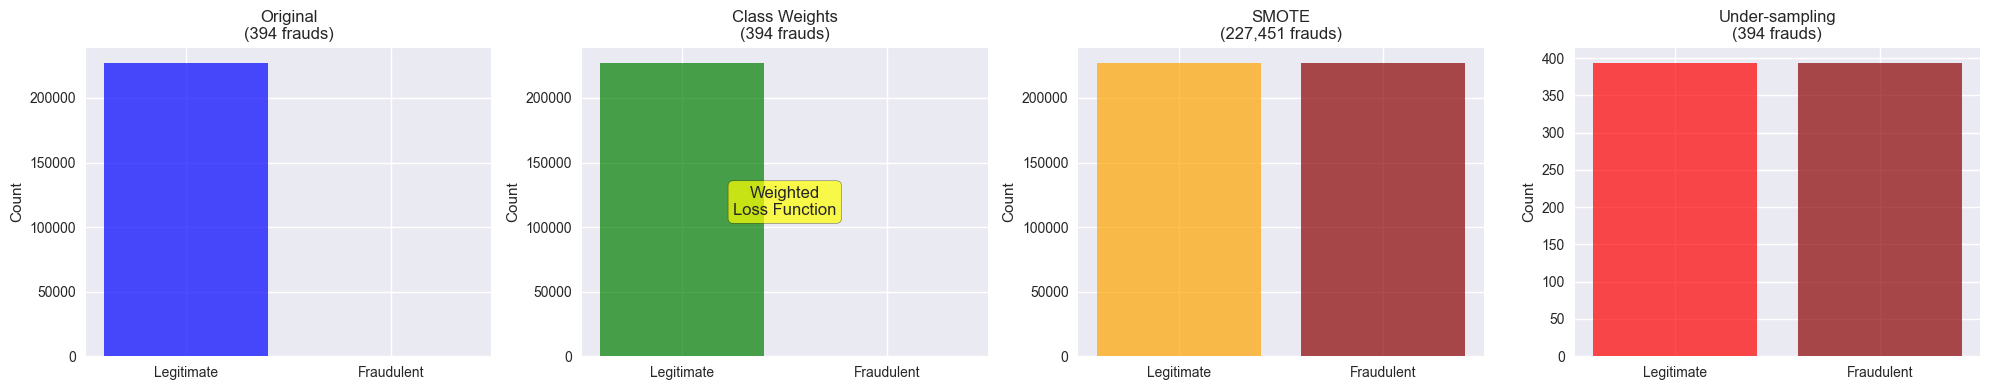

In [8]:
# Class Imbalance Handling Strategies
print("Class Imbalance strategies")

# Strategy 1: Class Weights
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

print(f"1. Class Weights Strategy:")
print(f"   Class 0 (Legitimate): {class_weight_dict[0]:.3f}")
print(f"   Class 1 (Fraudulent): {class_weight_dict[1]:.3f}")
print(f"   Ratio: {class_weight_dict[1]/class_weight_dict[0]:.1f}:1")

# Strategy 2: SMOTE (Synthetic Minority Over-sampling)
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print(f"\n2. SMOTE Over-sampling:")
print(f"   Original training size: {len(X_train):,}")
print(f"   After SMOTE: {len(X_train_smote):,}")
print(f"   Original fraud rate: {y_train.mean():.4f}")
print(f"   After SMOTE fraud rate: {y_train_smote.mean():.4f}")

# Strategy 3: Random Under-sampling
undersample = RandomUnderSampler(random_state=42)
X_train_under, y_train_under = undersample.fit_resample(X_train, y_train)

print(f"\n3. Random Under-sampling:")
print(f"   Original training size: {len(X_train):,}")
print(f"   After under-sampling: {len(X_train_under):,}")
print(f"   Original fraud rate: {y_train.mean():.4f}")
print(f"   After under-sampling fraud rate: {y_train_under.mean():.4f}")

# Visualize the effect of different strategies
fig, axes = plt.subplots(1, 4, figsize=(20, 4))

strategies = [
    ("Original", y_train, 'blue'),
    ("Class Weights", y_train, 'green'),  # Same distribution, but weighted
    ("SMOTE", y_train_smote, 'orange'),
    ("Under-sampling", y_train_under, 'red')
]

for i, (name, y_data, color) in enumerate(strategies):
    counts = y_data.value_counts()
    axes[i].bar(['Legitimate', 'Fraudulent'], counts.values, color=[color, 'darkred'], alpha=0.7)
    axes[i].set_title(f'{name}\n({counts[1]:,} frauds)')
    axes[i].set_ylabel('Count')
    if i == 1:  # Class weights don't change distribution
        axes[i].text(0.5, 0.5, 'Weighted\nLoss Function', transform=axes[i].transAxes,
                    ha='center', va='center', fontsize=12, bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))

plt.tight_layout()
plt.show()


### Which strategy should we use?

In [9]:
# Quick evaluation function
def quick_test_model(model, X_train_data, y_train_data, X_test_data, y_test_data, strategy_name):
    """Quick test of a model with a specific sampling strategy"""
    model.fit(X_train_data, y_train_data)
    y_pred = model.predict(X_test_data)
    y_pred_proba = model.predict_proba(X_test_data)[:, 1]
    
    f1 = f1_score(y_test_data, y_pred)
    roc_auc = roc_auc_score(y_test_data, y_pred_proba)
    precision = precision_score(y_test_data, y_pred)
    recall = recall_score(y_test_data, y_pred)
    
    return {
        'strategy': strategy_name,
        'f1': f1,
        'roc_auc': roc_auc,
        'precision': precision,
        'recall': recall,
        'score': f1 * 0.6 + roc_auc * 0.4  # Weighted score favoring F1
    }

# Test each algorithm with different sampling strategies
sampling_results = {}

# 1. LOGISTIC REGRESSION TESTING
print("\n Testing Logistic Regression:\n")
lr_strategies = []

# LR with Class Weights
lr_weights = LogisticRegression(random_state=42, class_weight='balanced', C=1, max_iter=1000)
lr_strategies.append(quick_test_model(lr_weights, X_train, y_train, X_test, y_test, "Class Weights"))

# LR with SMOTE  
lr_smote = LogisticRegression(random_state=42, C=1, max_iter=1000)
lr_strategies.append(quick_test_model(lr_smote, X_train_smote, y_train_smote, X_test, y_test, "SMOTE"))

# LR with Undersampling
lr_under = LogisticRegression(random_state=42, C=1, max_iter=1000)
lr_strategies.append(quick_test_model(lr_under, X_train_under, y_train_under, X_test, y_test, "Undersampling"))

best_lr = max(lr_strategies, key=lambda x: x['score'])
sampling_results['Logistic Regression'] = best_lr
print(f"   Best for LR: {best_lr['strategy']} (F1: {best_lr['f1']:.3f}, AUC: {best_lr['roc_auc']:.3f})")

# 2. RANDOM FOREST TESTING
print("\n Testing Random Forest:\n")
rf_strategies = []

# RF with Class Weights
rf_weights = RandomForestClassifier(random_state=42, n_estimators=100, class_weight='balanced')
rf_strategies.append(quick_test_model(rf_weights, X_train, y_train, X_test, y_test, "Class Weights"))

# RF with SMOTE
rf_smote = RandomForestClassifier(random_state=42, n_estimators=100)
rf_strategies.append(quick_test_model(rf_smote, X_train_smote, y_train_smote, X_test, y_test, "SMOTE"))

# RF with Undersampling
rf_under = RandomForestClassifier(random_state=42, n_estimators=100)
rf_strategies.append(quick_test_model(rf_under, X_train_under, y_train_under, X_test, y_test, "Undersampling"))

best_rf = max(rf_strategies, key=lambda x: x['score'])
sampling_results['Random Forest'] = best_rf
print(f"   Best for RF: {best_rf['strategy']} (F1: {best_rf['f1']:.3f}, AUC: {best_rf['roc_auc']:.3f})")

# 3. XGBOOST TESTING
print("\n Testing XGBoost:\n")
xgb_strategies = []

# XGBoost with Class Weights (scale_pos_weight)
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
xgb_weights = xgb.XGBClassifier(random_state=42, n_estimators=100, 
                               scale_pos_weight=scale_pos_weight, eval_metric='logloss')
xgb_strategies.append(quick_test_model(xgb_weights, X_train, y_train, X_test, y_test, "Class Weights"))

# XGBoost with SMOTE
xgb_smote = xgb.XGBClassifier(random_state=42, n_estimators=100, eval_metric='logloss')
xgb_strategies.append(quick_test_model(xgb_smote, X_train_smote, y_train_smote, X_test, y_test, "SMOTE"))

# XGBoost with Undersampling  
xgb_under = xgb.XGBClassifier(random_state=42, n_estimators=100, eval_metric='logloss')
xgb_strategies.append(quick_test_model(xgb_under, X_train_under, y_train_under, X_test, y_test, "Undersampling"))

best_xgb = max(xgb_strategies, key=lambda x: x['score'])
sampling_results['XGBoost'] = best_xgb
print(f"   Best for XGBoost: {best_xgb['strategy']} (F1: {best_xgb['f1']:.3f}, AUC: {best_xgb['roc_auc']:.3f})")

# SUMMARY TABLE
print("\n Sampling Strategy Summary:\n")
results_summary = []
for model, result in sampling_results.items():
    results_summary.append({
        'Model': model,
        'Best Sampling': result['strategy'], 
        'F1 Score': result['f1'],
        'ROC AUC': result['roc_auc'],
        'Precision': result['precision'],
        'Recall': result['recall']
    })

summary_df = pd.DataFrame(results_summary)
display(summary_df.round(4))

# Set the chosen strategies for main implementation
chosen_strategies = {
    'lr': best_lr['strategy'],
    'rf': best_rf['strategy'], 
    'xgb': best_xgb['strategy']
}

print(f"\n Optimal sampling strategies ")
print(f"   Logistic Regression: {chosen_strategies['lr']}")
print(f"   Random Forest: {chosen_strategies['rf']}")
print(f"   XGBoost: {chosen_strategies['xgb']}")
print(f"   Autoencoder: Anomaly Detection (unchanged)")



 Testing Logistic Regression:

   Best for LR: Class Weights (F1: 0.114, AUC: 0.972)

 Testing Random Forest:

   Best for RF: SMOTE (F1: 0.848, AUC: 0.968)

 Testing XGBoost:

   Best for XGBoost: Class Weights (F1: 0.859, AUC: 0.968)

 Sampling Strategy Summary:



,Model,Best Sampling,F1 Score,ROC AUC,Precision,Recall
0,Logistic Regression,Class Weights,0.1144,0.9721,0.0610,0.9184
1,Random Forest,SMOTE,0.8482,0.9684,0.8710,0.8265
2,XGBoost,Class Weights,0.8586,0.9682,0.8817,0.8367



 Optimal sampling strategies 
   Logistic Regression: Class Weights
   Random Forest: SMOTE
   XGBoost: Class Weights
   Autoencoder: Anomaly Detection (unchanged)


# 4. Model Implementation and Training

Now we'll implement and compare the four different approaches:


## 4A. Logistic Regression (Baseline Model)

Logistic regression serves as our baseline model due to its simplicity.


LR - Baseline:

Class weights: {np.int64(0): np.float64(0.5008661206149896), np.int64(1): np.float64(289.14340101522845)}
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best LR parameters: {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
   ROC AUC: 0.9721
   PR AUC: 0.7639
   F1 Score: 0.1144
   Accuracy: 0.9755
   Precision @ 80% Recall: 0.8298


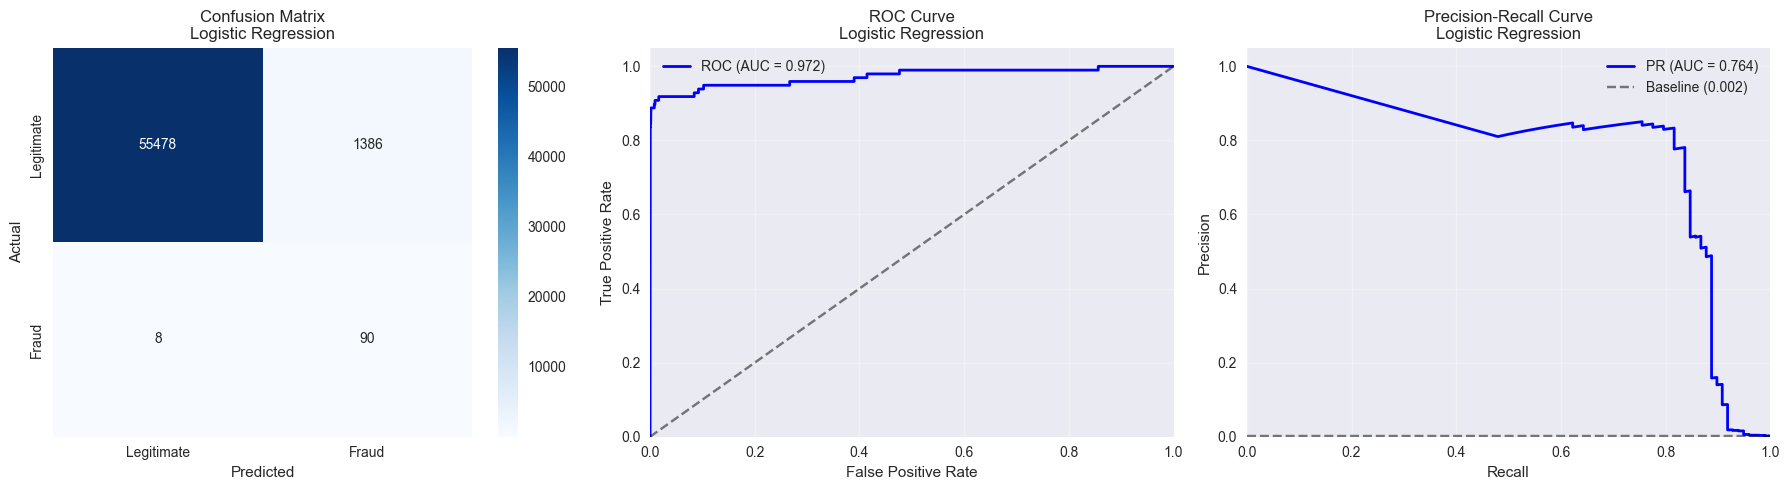

In [10]:
# Logistic Regression Implementation
print("LR - Baseline:\n")

# Calculate class weights dynamically
from sklearn.utils import class_weight
weights = class_weight.compute_class_weight(
    'balanced', classes=np.unique(y_train), y=y_train
)
class_weight_dict = dict(zip(np.unique(y_train), weights))
print(f"Class weights: {class_weight_dict}")

# Set parameters
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs']
}

lr = LogisticRegression(random_state=42, class_weight=class_weight_dict)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(
    lr, param_grid, cv=cv, scoring='roc_auc', n_jobs=-1, verbose=1
)
grid_search.fit(X_train, y_train)
lr_model = grid_search.best_estimator_
print(f"Best LR parameters: {grid_search.best_params_}")

# Fit the model
start_time = datetime.now()
lr_model.fit(X_train, y_train)
lr_train_time = (datetime.now() - start_time).total_seconds()

# Make predictions
y_pred_lr = lr_model.predict(X_test)
y_pred_proba_lr = lr_model.predict_proba(X_test)[:, 1]

# Calculate metrics
lr_accuracy = accuracy_score(y_test, y_pred_lr)
lr_f1 = f1_score(y_test, y_pred_lr)
lr_roc_auc = roc_auc_score(y_test, y_pred_proba_lr)

# Calculate precision at different recall levels
precision_lr, recall_lr, _ = precision_recall_curve(y_test, y_pred_proba_lr)
lr_pr_auc = auc(recall_lr, precision_lr)

# Find precision at 80% recall
target_recall = 0.8
idx_80_recall = np.argmax(recall_lr <= target_recall)
precision_at_80_recall_lr = precision_lr[idx_80_recall] if idx_80_recall < len(precision_lr) else precision_lr[-1]

print(f"   ROC AUC: {lr_roc_auc:.4f}")
print(f"   PR AUC: {lr_pr_auc:.4f}")
print(f"   F1 Score: {lr_f1:.4f}")
print(f"   Accuracy: {lr_accuracy:.4f}")
print(f"   Precision @ 80% Recall: {precision_at_80_recall_lr:.4f}")

# Confusion Matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Confusion Matrix
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion Matrix\nLogistic Regression')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_xticklabels(['Legitimate', 'Fraud'])
axes[0].set_yticklabels(['Legitimate', 'Fraud'])

# ROC Curve
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba_lr)
axes[1].plot(fpr_lr, tpr_lr, color='blue', linewidth=2, label=f'ROC (AUC = {lr_roc_auc:.3f})')
axes[1].plot([0, 1], [0, 1], 'k--', alpha=0.5)
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve\nLogistic Regression')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Precision-Recall Curve
axes[2].plot(recall_lr, precision_lr, color='blue', linewidth=2, label=f'PR (AUC = {lr_pr_auc:.3f})')
axes[2].axhline(y=y_test.mean(), color='k', linestyle='--', alpha=0.5, label=f'Baseline ({y_test.mean():.3f})')
axes[2].set_xlim([0.0, 1.0])
axes[2].set_ylim([0.0, 1.05])
axes[2].set_xlabel('Recall')
axes[2].set_ylabel('Precision')
axes[2].set_title('Precision-Recall Curve\nLogistic Regression')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4B. XGBoost (Best Performing Model)



XGBoost
Calculated scale_pos_weight: 577.3
   ROC AUC: 0.9787
   PR AUC: 0.8683
   F1 Score: 0.8454
   Accuracy: 0.9995
   Precision @ 80% Recall: 0.8864

Feature Importance:
    1. V14   : 0.4193
    2. V10   : 0.1475
    3. V4    : 0.0572
    4. V12   : 0.0498
    5. V20   : 0.0289
    6. V17   : 0.0255
    7. V8    : 0.0189
    8. Amount: 0.0187
    9. V7    : 0.0173
   10. V19   : 0.0167


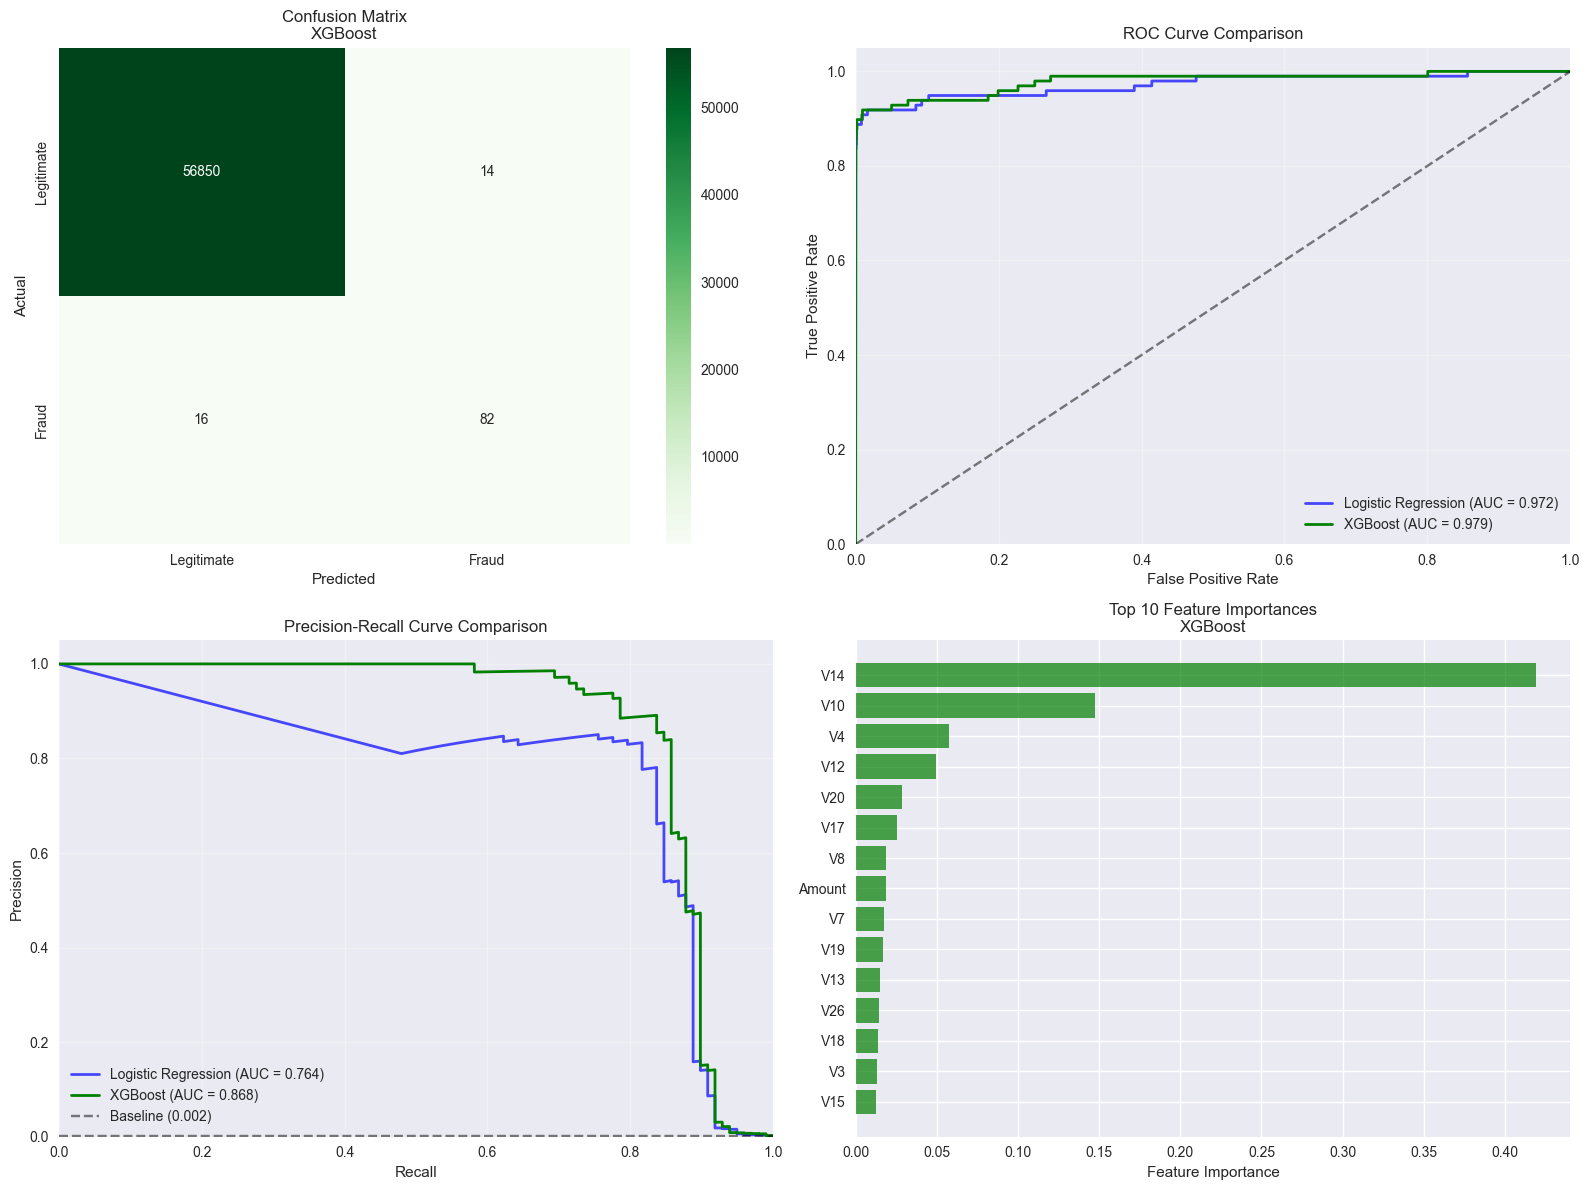

In [11]:
print("XGBoost")

# Calculate scale_pos_weight dynamically
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
print(f"Calculated scale_pos_weight: {scale_pos_weight:.1f}")

# Set parameters
xgb_params = {
    'learning_rate': 0.05,
    'max_depth': 8,
    'n_estimators': 200,
    'scale_pos_weight': scale_pos_weight,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': 42,
    'use_label_encoder': False,
    'eval_metric': 'logloss',
    'n_jobs': -1
}

# Initialize and train XGBoost
xgb_model = xgb.XGBClassifier(**xgb_params)

start_time = datetime.now()
xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
xgb_train_time = (datetime.now() - start_time).total_seconds()

# Make predictions
y_pred_xgb = xgb_model.predict(X_test)
y_pred_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

# Calculate metrics
xgb_accuracy = accuracy_score(y_test, y_pred_xgb)
xgb_f1 = f1_score(y_test, y_pred_xgb)
xgb_roc_auc = roc_auc_score(y_test, y_pred_proba_xgb)

# Precision-Recall metrics
precision_xgb, recall_xgb, _ = precision_recall_curve(y_test, y_pred_proba_xgb)
xgb_pr_auc = auc(recall_xgb, precision_xgb)

# Find precision at 80% recall
idx_80_recall_xgb = np.argmax(recall_xgb <= target_recall)
precision_at_80_recall_xgb = precision_xgb[idx_80_recall_xgb] if idx_80_recall_xgb < len(precision_xgb) else precision_xgb[-1]

print(f"   ROC AUC: {xgb_roc_auc:.4f}")
print(f"   PR AUC: {xgb_pr_auc:.4f}")
print(f"   F1 Score: {xgb_f1:.4f}")
print(f"   Accuracy: {xgb_accuracy:.4f}")
print(f"   Precision @ 80% Recall: {precision_at_80_recall_xgb:.4f}")

# Feature importance analysis 
feature_importance = pd.DataFrame({
    'Feature': X_train_raw.columns, 
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False)

print(f"\nFeature Importance:")
for i, (idx, row) in enumerate(feature_importance.head(10).iterrows()):
    print(f"   {i+1:2d}. {row['Feature']:6s}: {row['Importance']:.4f}")

# Confusion Matrix
cm_xgb = confusion_matrix(y_test, y_pred_xgb)

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Confusion Matrix
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Greens', ax=axes[0, 0])
axes[0, 0].set_title('Confusion Matrix\nXGBoost')
axes[0, 0].set_xlabel('Predicted')
axes[0, 0].set_ylabel('Actual')
axes[0, 0].set_xticklabels(['Legitimate', 'Fraud'])
axes[0, 0].set_yticklabels(['Legitimate', 'Fraud'])

# ROC Curve Comparison
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_proba_xgb)
axes[0, 1].plot(fpr_lr, tpr_lr, color='blue', linewidth=2, alpha=0.7, label=f'Logistic Regression (AUC = {lr_roc_auc:.3f})')
axes[0, 1].plot(fpr_xgb, tpr_xgb, color='green', linewidth=2, label=f'XGBoost (AUC = {xgb_roc_auc:.3f})')
axes[0, 1].plot([0, 1], [0, 1], 'k--', alpha=0.5)
axes[0, 1].set_xlim([0.0, 1.0])
axes[0, 1].set_ylim([0.0, 1.05])
axes[0, 1].set_xlabel('False Positive Rate')
axes[0, 1].set_ylabel('True Positive Rate')
axes[0, 1].set_title('ROC Curve Comparison')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Precision-Recall Curve Comparison
axes[1, 0].plot(recall_lr, precision_lr, color='blue', linewidth=2, alpha=0.7, label=f'Logistic Regression (AUC = {lr_pr_auc:.3f})')
axes[1, 0].plot(recall_xgb, precision_xgb, color='green', linewidth=2, label=f'XGBoost (AUC = {xgb_pr_auc:.3f})')
axes[1, 0].axhline(y=y_test.mean(), color='k', linestyle='--', alpha=0.5, label=f'Baseline ({y_test.mean():.3f})')
axes[1, 0].set_xlim([0.0, 1.0])
axes[1, 0].set_ylim([0.0, 1.05])
axes[1, 0].set_xlabel('Recall')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].set_title('Precision-Recall Curve Comparison')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Feature Importance
top_features = feature_importance.head(15)
axes[1, 1].barh(range(len(top_features)), top_features['Importance'], color='green', alpha=0.7)
axes[1, 1].set_yticks(range(len(top_features)))
axes[1, 1].set_yticklabels(top_features['Feature'])
axes[1, 1].set_xlabel('Feature Importance')
axes[1, 1].set_title('Top 10 Feature Importances\nXGBoost')
axes[1, 1].invert_yaxis()

plt.tight_layout()
plt.show()

RF
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best RF parameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100}
   ROC AUC: 0.9678
   PR AUC: 0.8602
   F1 Score: 0.7805
   Accuracy: 0.9992
   Precision @ 80% Recall: 0.8041

Top 10 most important features (Random Forest):
    1. V14   : 0.1927
    2. V10   : 0.1118
    3. V4    : 0.1082
    4. V12   : 0.0964
    5. V17   : 0.0861
    6. V3    : 0.0629
    7. V11   : 0.0532
    8. V16   : 0.0452
    9. V2    : 0.0379
   10. V9    : 0.0254


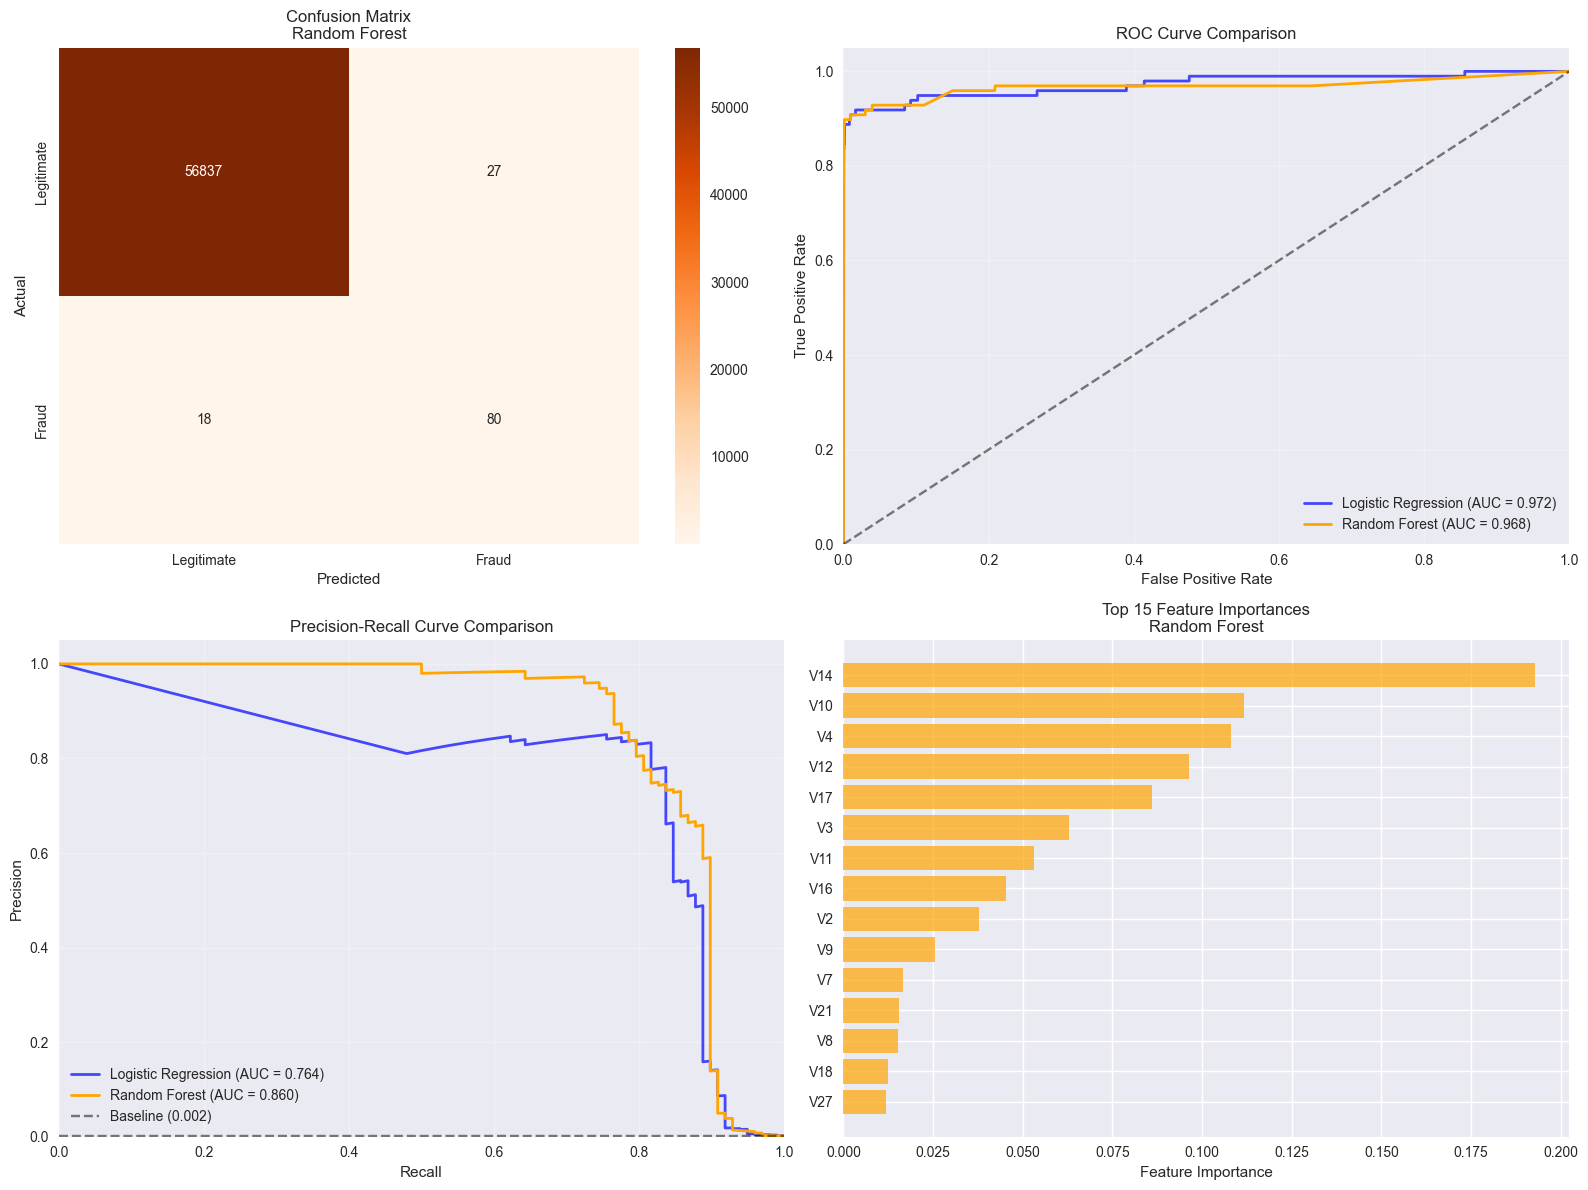

In [17]:
print("RF")

# Set parameters
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}

rf = RandomForestClassifier(random_state=42, n_jobs=-1)
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
grid_search = GridSearchCV(
    rf, param_grid, cv=cv, scoring='roc_auc', n_jobs=-1, verbose=1
)

grid_search.fit(X_train_smote, y_train_smote)
rf_model = grid_search.best_estimator_
print(f"Best RF parameters: {grid_search.best_params_}")

start_time = datetime.now()
rf_model.fit(X_train_smote, y_train_smote)
rf_train_time = (datetime.now() - start_time).total_seconds()

# Make predictions
y_pred_rf = rf_model.predict(X_test)
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# Calculate metrics
rf_accuracy = accuracy_score(y_test, y_pred_rf)
rf_f1 = f1_score(y_test, y_pred_rf)
rf_roc_auc = roc_auc_score(y_test, y_pred_proba_rf)

# Precision-Recall metrics
precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_pred_proba_rf)
rf_pr_auc = auc(recall_rf, precision_rf)

# Find precision at 80% recall
target_recall = 0.8
idx_80_recall_rf = np.argmax(recall_rf <= target_recall)
precision_at_80_recall_rf = precision_rf[idx_80_recall_rf] if idx_80_recall_rf < len(precision_rf) else precision_rf[-1]

print(f"   ROC AUC: {rf_roc_auc:.4f}")
print(f"   PR AUC: {rf_pr_auc:.4f}")
print(f"   F1 Score: {rf_f1:.4f}")
print(f"   Accuracy: {rf_accuracy:.4f}")
print(f"   Precision @ 80% Recall: {precision_at_80_recall_rf:.4f}")

# Feature importance analysis
rf_feature_importance = pd.DataFrame({
    'Feature': X_train_raw.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print(f"\nTop 10 most important features (Random Forest):")
for i, (idx, row) in enumerate(rf_feature_importance.head(10).iterrows()):
    print(f"   {i+1:2d}. {row['Feature']:6s}: {row['Importance']:.4f}")

# Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Confusion Matrix
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Oranges', ax=axes[0, 0])
axes[0, 0].set_title('Confusion Matrix\nRandom Forest')
axes[0, 0].set_xlabel('Predicted')
axes[0, 0].set_ylabel('Actual')
axes[0, 0].set_xticklabels(['Legitimate', 'Fraud'])
axes[0, 0].set_yticklabels(['Legitimate', 'Fraud'])

# ROC Curve Comparison
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)
axes[0, 1].plot(fpr_lr, tpr_lr, color='blue', linewidth=2, alpha=0.7, label=f'Logistic Regression (AUC = {lr_roc_auc:.3f})')
axes[0, 1].plot(fpr_rf, tpr_rf, color='orange', linewidth=2, label=f'Random Forest (AUC = {rf_roc_auc:.3f})')
axes[0, 1].plot([0, 1], [0, 1], 'k--', alpha=0.5)
axes[0, 1].set_xlim([0.0, 1.0])
axes[0, 1].set_ylim([0.0, 1.05])
axes[0, 1].set_xlabel('False Positive Rate')
axes[0, 1].set_ylabel('True Positive Rate')
axes[0, 1].set_title('ROC Curve Comparison')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Precision-Recall Curve Comparison
axes[1, 0].plot(recall_lr, precision_lr, color='blue', linewidth=2, alpha=0.7, label=f'Logistic Regression (AUC = {lr_pr_auc:.3f})')
axes[1, 0].plot(recall_rf, precision_rf, color='orange', linewidth=2, label=f'Random Forest (AUC = {rf_pr_auc:.3f})')
axes[1, 0].axhline(y=y_test.mean(), color='k', linestyle='--', alpha=0.5, label=f'Baseline ({y_test.mean():.3f})')
axes[1, 0].set_xlim([0.0, 1.0])
axes[1, 0].set_ylim([0.0, 1.05])
axes[1, 0].set_xlabel('Recall')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].set_title('Precision-Recall Curve Comparison')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Feature Importance
top_features_rf = rf_feature_importance.head(15)
axes[1, 1].barh(range(len(top_features_rf)), top_features_rf['Importance'], color='orange', alpha=0.7)
axes[1, 1].set_yticks(range(len(top_features_rf)))
axes[1, 1].set_yticklabels(top_features_rf['Feature'])
axes[1, 1].set_xlabel('Feature Importance')
axes[1, 1].set_title('Top 15 Feature Importances\nRandom Forest')
axes[1, 1].invert_yaxis()

plt.tight_layout()
plt.show()

Auto Encoder:

Training autoencoder on 227,451 legitimate transactions


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 20)             │           620 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 20)             │            80 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 20)             │           220 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 20)             │            80 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 30)             │           630 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,840 (7.19 KB)

 Trainable params: 1,760 (6.88 KB)

 Non-trainable params: 80 (320.00 B)


Training autoencoder:

Epoch 1/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.9506 - val_loss: 0.5622 - learning_rate: 0.0010
Epoch 2/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.5637 - val_loss: 0.4680 - learning_rate: 0.0010
Epoch 3/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4747 - val_loss: 0.4191 - learning_rate: 0.0010
Epoch 4/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4205 - val_loss: 0.3899 - learning_rate: 0.0010
Epoch 5/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3949 - val_loss: 0.3691 - learning_rate: 0.0010
Epoch 6/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3822 - val_loss: 0.3689 - learning_rate: 0.0010
Epoch 7/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3748 - val_loss: 0.3628 - learning_rate: 0.0010
Epoch 8/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3676 - val_loss: 0.3559 - learning_rate: 0.0010
Epoch 9/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.3616 - val_loss: 0.3491 -

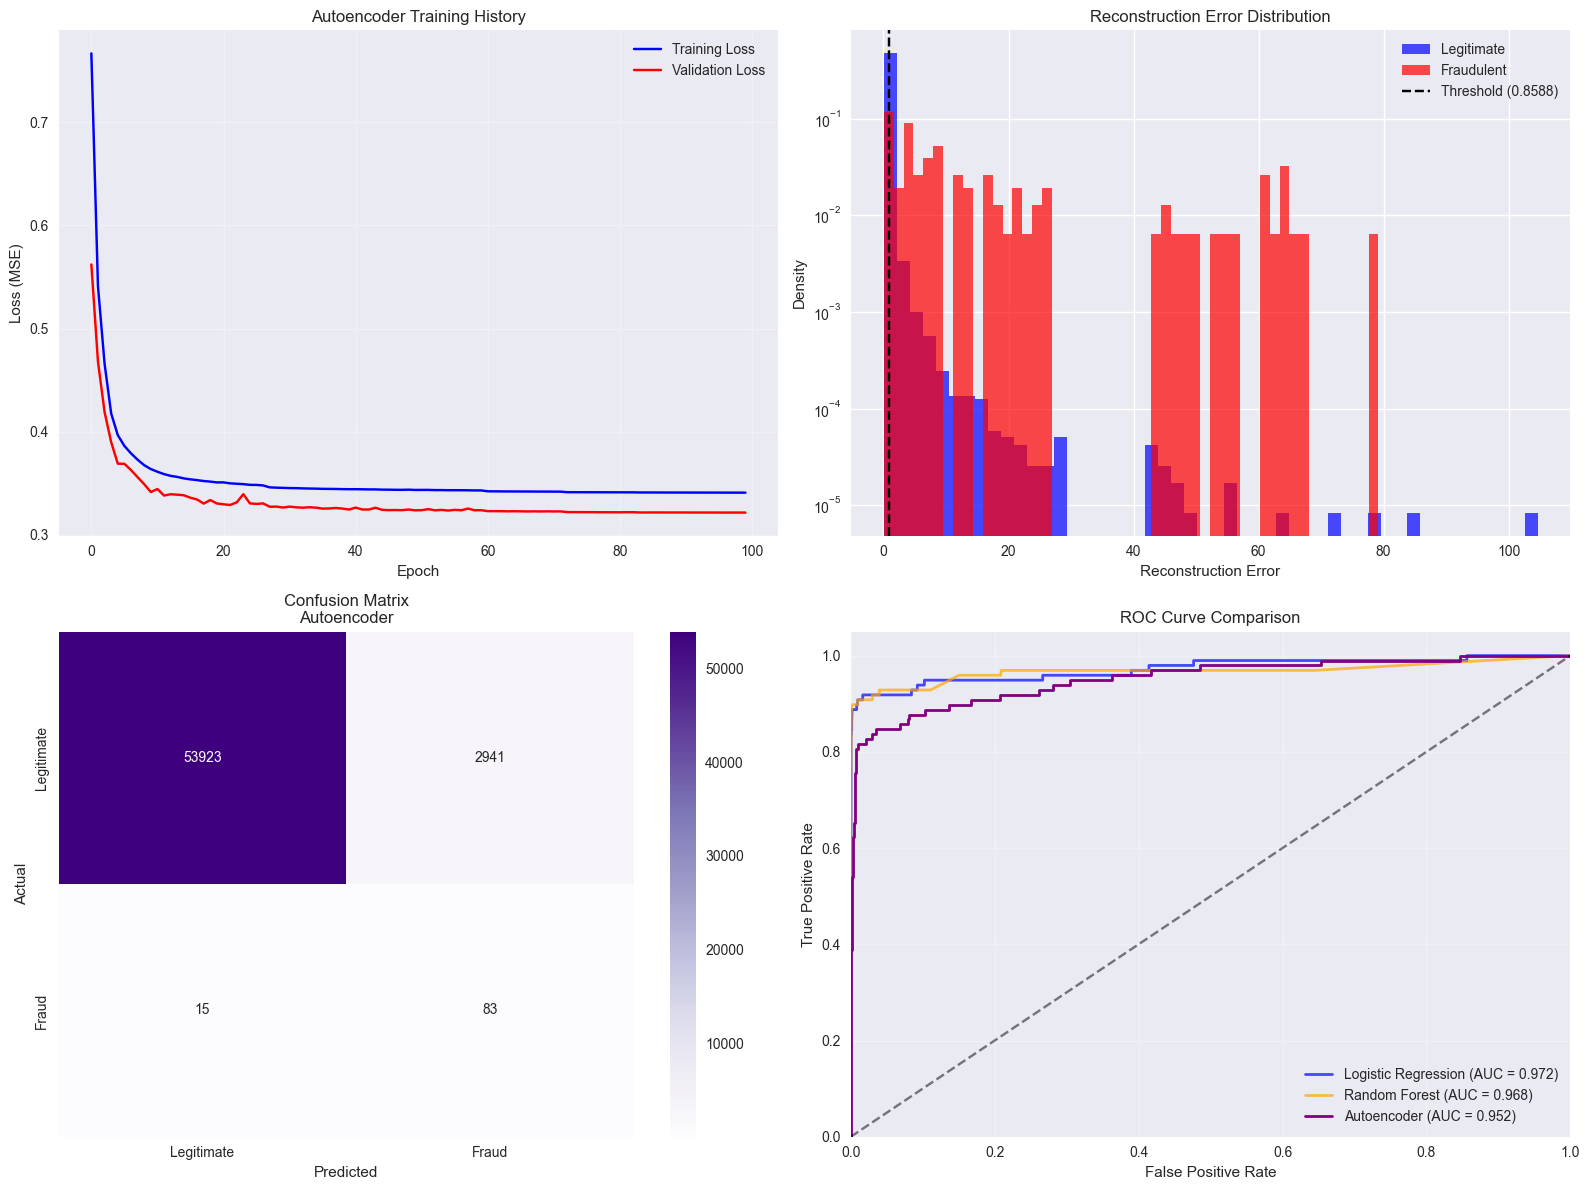

In [13]:
# Auto Encoder Implementation
print("Auto Encoder:\n")

# Prepare data for autoencoder (train only on legitimate transactions)
X_train_legit = X_train[y_train == 0]  
print(f"Training autoencoder on {len(X_train_legit):,} legitimate transactions")

# Define autoencoder architecture
input_dim = X_train.shape[1]

# Build the autoencoder model
def build_autoencoder(input_dim):
    # Input layer
    input_layer = layers.Input(shape=(input_dim,))

    # Encoder
    encoded = layers.Dense(20, activation='relu')(input_layer)
    encoded = layers.BatchNormalization()(encoded)
    encoded = layers.Dense(10, activation='relu')(encoded)

    # Decoder
    decoded = layers.Dense(20, activation='relu')(encoded)
    decoded = layers.BatchNormalization()(decoded)
    decoded = layers.Dense(input_dim, activation='linear')(decoded)

    # Create the autoencoder model
    autoencoder = Model(input_layer, decoded)

    return autoencoder

# Build and compile the model
autoencoder = build_autoencoder(input_dim)
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.summary()

# Early stopping and learning rate reduction
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=0.0001
)

# Train the autoencoder 
print(f"\nTraining autoencoder:\n")
start_time = datetime.now()

# Train
history = autoencoder.fit(
    X_train_legit, X_train_legit,
    epochs=100,
    batch_size=256,
    validation_split=0.1,
    callbacks=[early_stopping, reduce_lr],
    verbose=1                      
)

ae_train_time = (datetime.now() - start_time).total_seconds()
print(f"Training completed in {ae_train_time:.2f} seconds")

# Calculate reconstruction error threshold
train_pred = autoencoder.predict(X_train_legit)
mse = np.mean(np.power(X_train_legit - train_pred, 2), axis=1)
ae_threshold = np.percentile(mse, 95)

print(f"\nAutoencoder Threshold:\n")
print(f"   Threshold (95th percentile): {ae_threshold:.6f}")

# Predict on test set
test_pred = autoencoder.predict(X_test)
test_mse = np.mean(np.power(X_test - test_pred, 2), axis=1)

# Convert to binary predictions
y_pred_ae = (test_mse > ae_threshold).astype(int)
y_pred_proba_ae_norm = test_mse / test_mse.max()

print(f"   Predicted frauds: {np.sum(y_pred_ae):,} / {len(y_pred_ae):,}")

# Calculate metrics
ae_accuracy = accuracy_score(y_test, y_pred_ae)
ae_f1 = f1_score(y_test, y_pred_ae)
ae_roc_auc = roc_auc_score(y_test, y_pred_proba_ae_norm)

# Precision-Recall metrics
precision_ae, recall_ae, _ = precision_recall_curve(y_test, y_pred_proba_ae_norm)
ae_pr_auc = auc(recall_ae, precision_ae)

# Find precision at 80% recall
target_recall = 0.8
idx_80_recall_ae = np.argmax(recall_ae <= target_recall)
precision_at_80_recall_ae = precision_ae[idx_80_recall_ae] if idx_80_recall_ae < len(precision_ae) else precision_ae[-1]

print(f"   ROC AUC: {ae_roc_auc:.4f}")
print(f"   PR AUC: {ae_pr_auc:.4f}")
print(f"   F1 Score: {ae_f1:.4f}")
print(f"   Accuracy: {ae_accuracy:.4f}")
print(f"   Precision @ 80% Recall: {precision_at_80_recall_ae:.4f}")

# Analyze reconstruction errors
legit_errors = test_mse[y_test == 0]
fraud_errors = test_mse[y_test == 1]

print(f"\nReconstruction Error Analysis:\n")
print(f"   Legitimate transactions - Mean: {legit_errors.mean():.6f}, Std: {legit_errors.std():.6f}")
print(f"   Fraudulent transactions - Mean: {fraud_errors.mean():.6f}, Std: {fraud_errors.std():.6f}")
print(f"   Separation ratio: {fraud_errors.mean() / legit_errors.mean():.2f}x")

# Confusion Matrix
cm_ae = confusion_matrix(y_test, y_pred_ae)

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Training History
axes[0, 0].plot(history.history['loss'], label='Training Loss', color='blue')
axes[0, 0].plot(history.history['val_loss'], label='Validation Loss', color='red')
axes[0, 0].set_title('Autoencoder Training History')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss (MSE)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Reconstruction Error Distribution
axes[0, 1].hist(legit_errors, bins=50, alpha=0.7, label='Legitimate', color='blue', density=True)
axes[0, 1].hist(fraud_errors, bins=50, alpha=0.7, label='Fraudulent', color='red', density=True)
axes[0, 1].axvline(ae_threshold, color='black', linestyle='--', label=f'Threshold ({ae_threshold:.4f})')
axes[0, 1].set_xlabel('Reconstruction Error')
axes[0, 1].set_ylabel('Density')
axes[0, 1].set_title('Reconstruction Error Distribution')
axes[0, 1].legend()
axes[0, 1].set_yscale('log')

# Confusion Matrix
sns.heatmap(cm_ae, annot=True, fmt='d', cmap='Purples', ax=axes[1, 0])
axes[1, 0].set_title('Confusion Matrix\nAutoencoder')
axes[1, 0].set_xlabel('Predicted')
axes[1, 0].set_ylabel('Actual')
axes[1, 0].set_xticklabels(['Legitimate', 'Fraud'])
axes[1, 0].set_yticklabels(['Legitimate', 'Fraud'])

# ROC Curve Comparison
fpr_ae, tpr_ae, _ = roc_curve(y_test, y_pred_proba_ae_norm)
axes[1, 1].plot(fpr_lr, tpr_lr, color='blue', linewidth=2, alpha=0.7, label=f'Logistic Regression (AUC = {lr_roc_auc:.3f})')
axes[1, 1].plot(fpr_rf, tpr_rf, color='orange', linewidth=2, alpha=0.7, label=f'Random Forest (AUC = {rf_roc_auc:.3f})')
axes[1, 1].plot(fpr_ae, tpr_ae, color='purple', linewidth=2, label=f'Autoencoder (AUC = {ae_roc_auc:.3f})')
axes[1, 1].plot([0, 1], [0, 1], 'k--', alpha=0.5)
axes[1, 1].set_xlim([0.0, 1.0])
axes[1, 1].set_ylim([0.0, 1.05])
axes[1, 1].set_xlabel('False Positive Rate')
axes[1, 1].set_ylabel('True Positive Rate')
axes[1, 1].set_title('ROC Curve Comparison')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 5. Model Comparison

Let's compare all our models


,Model,ROC AUC,PR AUC,F1 Score,Precision@80% Recall,Training Time (s)
0,Logistic Regression,0.9721,0.7639,0.1144,0.8298,0.5675
1,Random Forest,0.9678,0.8602,0.7805,0.8041,51.4452
2,Autoencoder,0.9518,0.3135,0.0532,0.1480,93.9828
3,XGBoost,0.9787,0.8683,0.8454,0.8864,2.8788



Logistic Regression:
   True Positives (Caught Fraud): 90
   False Positives (Blocked Legit): 1,386
   False Negatives (Missed Fraud): 8
   Total Business Cost: €123,349.05
   Cost per Transaction: €2.1655

Random Forest:
   True Positives (Caught Fraud): 80
   False Positives (Blocked Legit): 27
   False Negatives (Missed Fraud): 18
   Total Business Cost: €4,583.66
   Cost per Transaction: €0.0805

Autoencoder:
   True Positives (Caught Fraud): 83
   False Positives (Blocked Legit): 2,941
   False Negatives (Missed Fraud): 15
   Total Business Cost: €261,497.07
   Cost per Transaction: €4.5907

XGBoost:
   True Positives (Caught Fraud): 82
   False Positives (Blocked Legit): 14
   False Negatives (Missed Fraud): 16
   Total Business Cost: €3,191.46
   Cost per Transaction: €0.0560
   Random Forest savings: €118,765.39 (96.3%)
   Autoencoder savings: €-138,148.02 (-112.0%)
   XGBoost savings: €120,157.59 (97.4%)


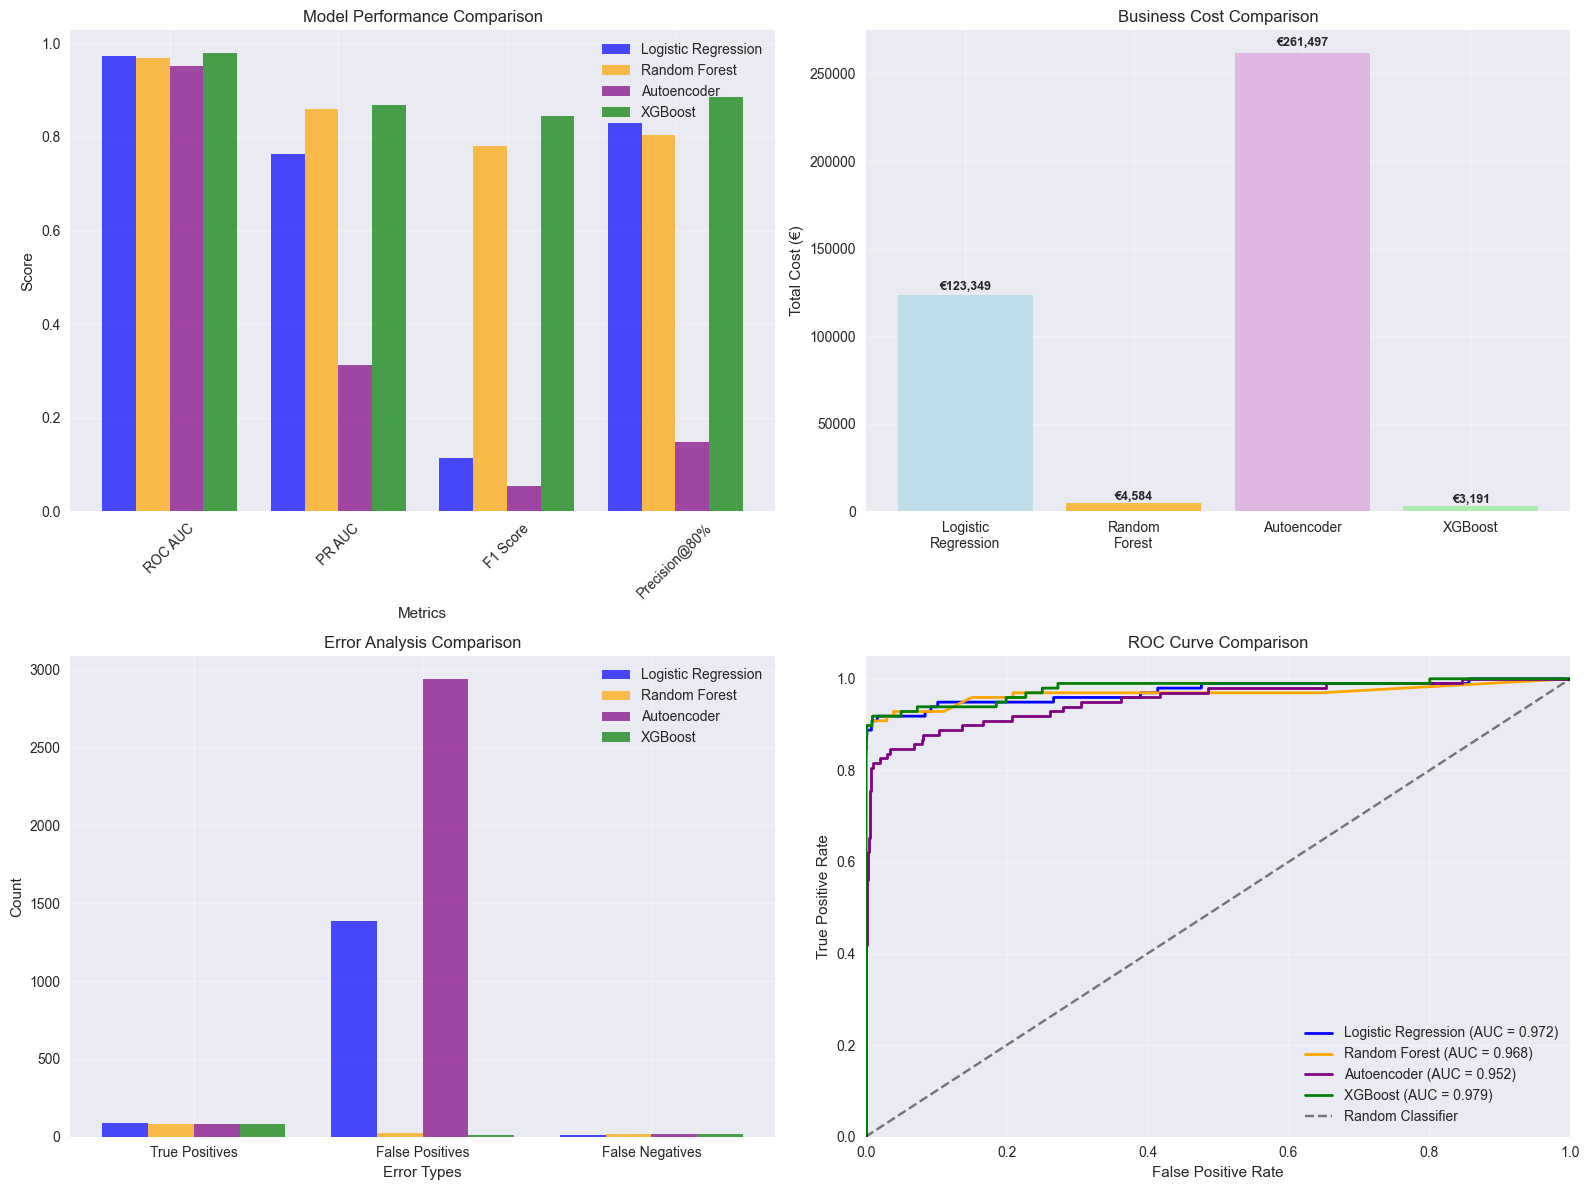

In [14]:
# Compile all results
models_results = {
    'Model': ['Logistic Regression', 'Random Forest', 'Autoencoder', 'XGBoost'],
    'ROC AUC': [lr_roc_auc, rf_roc_auc, ae_roc_auc, xgb_roc_auc],
    'PR AUC': [lr_pr_auc, rf_pr_auc, ae_pr_auc, xgb_pr_auc],
    'F1 Score': [lr_f1, rf_f1, ae_f1, xgb_f1],
    'Precision@80% Recall': [precision_at_80_recall_lr, precision_at_80_recall_rf, precision_at_80_recall_ae, precision_at_80_recall_xgb],
    'Training Time (s)': [lr_train_time, rf_train_time, ae_train_time, xgb_train_time]
}

results_df = pd.DataFrame(models_results)
display(results_df.round(4))


# Calculate business metrics for each model
def calculate_business_impact(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    # Business assumptions
    cost_per_false_positive = 88.291022    # Average non fraud transaction (EDA)
    cost_per_false_negative = 122.211321   # Average fraud transaction (EDA)
    

    total_cost = (fp * cost_per_false_positive) + (fn * cost_per_false_negative)

    print(f"\n{model_name}:")
    print(f"   True Positives (Caught Fraud): {tp:,}")
    print(f"   False Positives (Blocked Legit): {fp:,}")
    print(f"   False Negatives (Missed Fraud): {fn:,}")
    print(f"   Total Business Cost: €{total_cost:,.2f}")
    print(f"   Cost per Transaction: €{total_cost/len(y_true):.4f}")

    return total_cost, tp, fp, fn

# Calculate for each model
lr_cost, lr_tp, lr_fp, lr_fn = calculate_business_impact(y_test, y_pred_lr, "Logistic Regression")
rf_cost, rf_tp, rf_fp, rf_fn = calculate_business_impact(y_test, y_pred_rf, "Random Forest")
ae_cost, ae_tp, ae_fp, ae_fn = calculate_business_impact(y_test, y_pred_ae, "Autoencoder")
xgb_cost, xgb_tp, xgb_fp, xgb_fn = calculate_business_impact(y_test, y_pred_xgb, "XGBoost")

# Cost savings comparison (baseline: Logistic Regression)
print(f"   Random Forest savings: €{lr_cost - rf_cost:,.2f} ({((lr_cost - rf_cost)/lr_cost)*100:.1f}%)")
print(f"   Autoencoder savings: €{lr_cost - ae_cost:,.2f} ({((lr_cost - ae_cost)/lr_cost)*100:.1f}%)")
print(f"   XGBoost savings: €{lr_cost - xgb_cost:,.2f} ({((lr_cost - xgb_cost)/lr_cost)*100:.1f}%)")

# Visualization of business impact
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Model Performance Comparison
metrics = ['ROC AUC', 'PR AUC', 'F1 Score', 'Precision@80%']
lr_scores = [lr_roc_auc, lr_pr_auc, lr_f1, precision_at_80_recall_lr]
rf_scores = [rf_roc_auc, rf_pr_auc, rf_f1, precision_at_80_recall_rf]
ae_scores = [ae_roc_auc, ae_pr_auc, ae_f1, precision_at_80_recall_ae]
xgb_scores = [xgb_roc_auc, xgb_pr_auc, xgb_f1, precision_at_80_recall_xgb]

x = np.arange(len(metrics))
width = 0.2

axes[0, 0].bar(x - 1.5*width, lr_scores, width, label='Logistic Regression', color='blue', alpha=0.7)
axes[0, 0].bar(x - 0.5*width, rf_scores, width, label='Random Forest', color='orange', alpha=0.7)
axes[0, 0].bar(x + 0.5*width, ae_scores, width, label='Autoencoder', color='purple', alpha=0.7)
axes[0, 0].bar(x + 1.5*width, xgb_scores, width, label='XGBoost', color='green', alpha=0.7)
axes[0, 0].set_xlabel('Metrics')
axes[0, 0].set_ylabel('Score')
axes[0, 0].set_title('Model Performance Comparison')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(metrics, rotation=45)
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Business Cost Comparison
models = ['Logistic\nRegression', 'Random\nForest', 'Autoencoder', 'XGBoost']
costs = [lr_cost, rf_cost, ae_cost, xgb_cost]
colors = ['lightblue', 'orange', 'plum', 'lightgreen']

bars = axes[0, 1].bar(models, costs, color=colors, alpha=0.7)
axes[0, 1].set_ylabel('Total Cost (€)')
axes[0, 1].set_title('Business Cost Comparison')
axes[0, 1].grid(True, alpha=0.3)

# Add cost values on bars
for bar, cost in zip(bars, costs):
    height = bar.get_height()
    axes[0, 1].text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                   f'€{cost:,.0f}', ha='center', va='bottom', fontweight='bold', fontsize=9)

# Confusion Matrix Comparison
confusion_data = {
    'Metric': ['True Positives', 'False Positives', 'False Negatives'],
    'Logistic Regression': [lr_tp, lr_fp, lr_fn],
    'Random Forest': [rf_tp, rf_fp, rf_fn],
    'Autoencoder': [ae_tp, ae_fp, ae_fn],
    'XGBoost': [xgb_tp, xgb_fp, xgb_fn]
}

conf_df = pd.DataFrame(confusion_data)
x = np.arange(len(conf_df['Metric']))

axes[1, 0].bar(x - 1.5*width, conf_df['Logistic Regression'], width,
               label='Logistic Regression', color='blue', alpha=0.7)
axes[1, 0].bar(x - 0.5*width, conf_df['Random Forest'], width,
               label='Random Forest', color='orange', alpha=0.7)
axes[1, 0].bar(x + 0.5*width, conf_df['Autoencoder'], width,
               label='Autoencoder', color='purple', alpha=0.7)
axes[1, 0].bar(x + 1.5*width, conf_df['XGBoost'], width,
               label='XGBoost', color='green', alpha=0.7)
axes[1, 0].set_xlabel('Error Types')
axes[1, 0].set_ylabel('Count')
axes[1, 0].set_title('Error Analysis Comparison')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(conf_df['Metric'])
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# ROC Curves Overlay
axes[1, 1].plot(fpr_lr, tpr_lr, color='blue', linewidth=2,
                label=f'Logistic Regression (AUC = {lr_roc_auc:.3f})')
axes[1, 1].plot(fpr_rf, tpr_rf, color='orange', linewidth=2,
                label=f'Random Forest (AUC = {rf_roc_auc:.3f})')
axes[1, 1].plot(fpr_ae, tpr_ae, color='purple', linewidth=2,
                label=f'Autoencoder (AUC = {ae_roc_auc:.3f})')
axes[1, 1].plot(fpr_xgb, tpr_xgb, color='green', linewidth=2,
                label=f'XGBoost (AUC = {xgb_roc_auc:.3f})')
axes[1, 1].plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random Classifier')
axes[1, 1].set_xlim([0.0, 1.0])
axes[1, 1].set_ylim([0.0, 1.05])
axes[1, 1].set_xlabel('False Positive Rate')
axes[1, 1].set_ylabel('True Positive Rate')
axes[1, 1].set_title('ROC Curve Comparison')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


# 6. Model Interpretability and SHAP Analysis

Understanding why our model makes certain predictions.


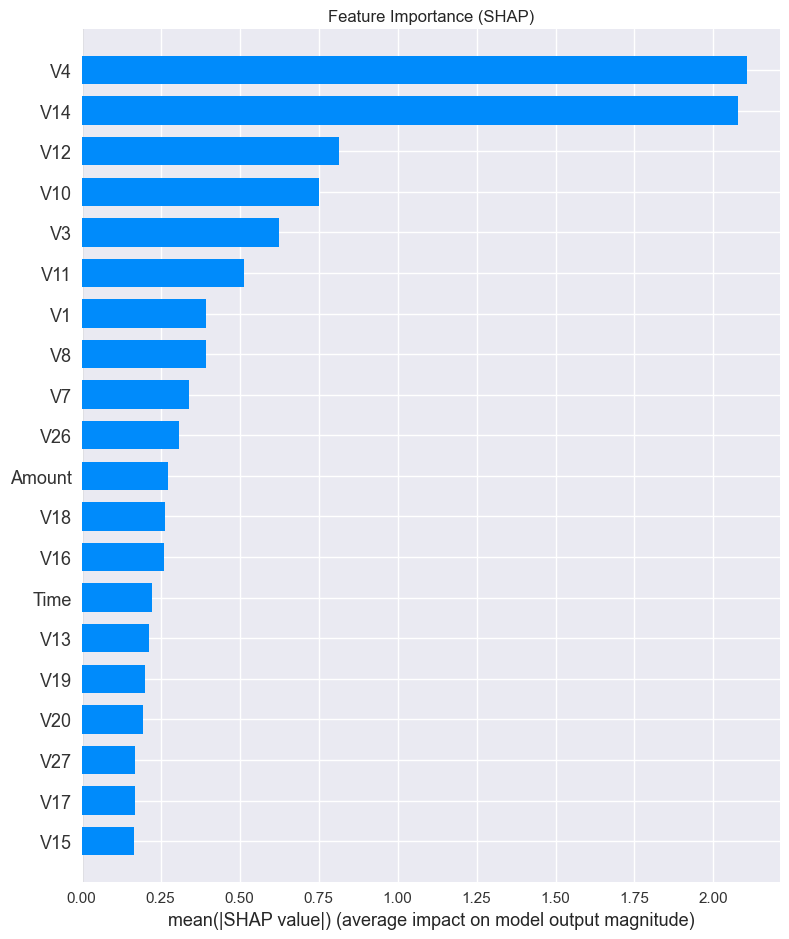

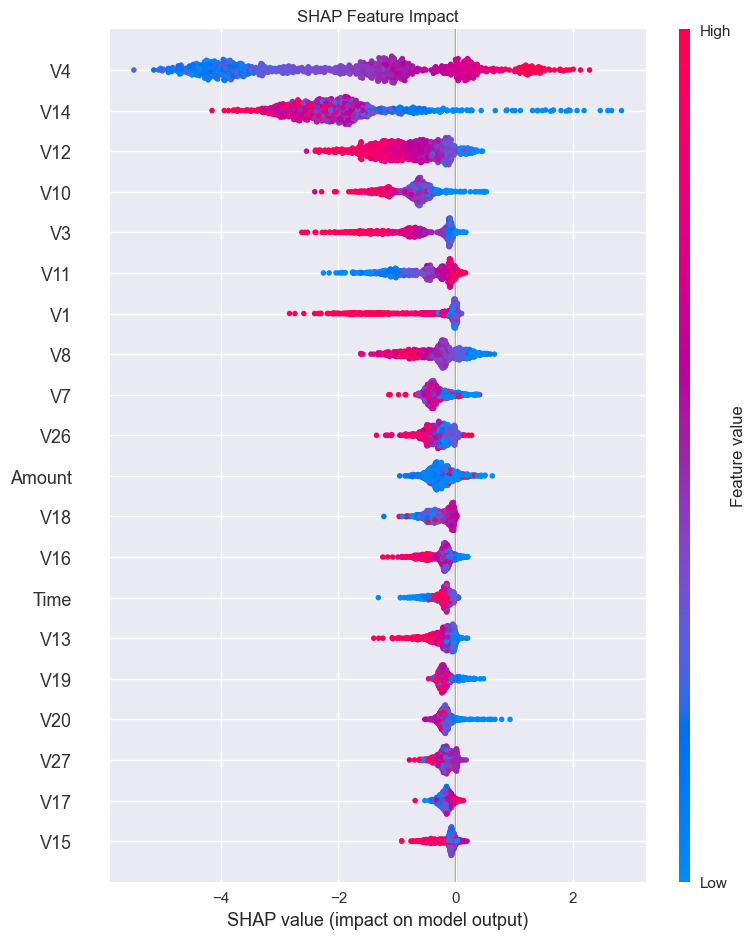


Top 10 most important features (SHAP Analysis):
    1. V4    : 2.1055
    2. V14   : 2.0783
    3. V12   : 0.8150
    4. V10   : 0.7526
    5. V3    : 0.6235
    6. V11   : 0.5149
    7. V1    : 0.3927
    8. V8    : 0.3927
    9. V7    : 0.3400
   10. V26   : 0.3076


In [15]:
# Initialize SHAP explainer for XGBoost (our best model)
explainer = shap.TreeExplainer(xgb_model)

# Calculate SHAP values on a sample of test data (for performance)
sample_size = 1000
sample_indices = np.random.choice(len(X_test), sample_size, replace=False)

# Use scaled data for SHAP (what the model was trained on)
X_test_sample_scaled = X_test[sample_indices]
X_test_sample_df = X_test_raw.iloc[sample_indices]  # For feature names

# Calculate SHAP values
shap_values = explainer.shap_values(X_test_sample_scaled)

# Summary plot (bar)
plt.figure(figsize=(10, 8))
shap.summary_plot(
    shap_values,
    X_test_sample_df,
    plot_type="bar",
    show=False
)
plt.title("Feature Importance (SHAP)")
plt.tight_layout()
plt.show()

# Detailed summary plot
plt.figure(figsize=(10, 8))
shap.summary_plot(
    shap_values,
    X_test_sample_df,
    show=False
)
plt.title("SHAP Feature Impact")
plt.tight_layout()
plt.show()

# Print feature importance rankings
feature_importance_shap = pd.DataFrame({
    'Feature': X_test_sample_df.columns,
    'SHAP_Importance': np.abs(shap_values).mean(0)
}).sort_values('SHAP_Importance', ascending=False)

print(f"\nTop 10 most important features (SHAP Analysis):")
for i, (idx, row) in enumerate(feature_importance_shap.head(10).iterrows()):
    print(f"   {i+1:2d}. {row['Feature']:6s}: {row['SHAP_Importance']:.4f}")

In [16]:
# Determine best model by F1 score 
models_f1_scores = {
    'Logistic Regression': lr_f1,
    'Random Forest': rf_f1,
    'Autoencoder': ae_f1,
    'XGBoost': xgb_f1
}


# set best model to XGBoost
best_model_name = 'XGBoost'
print(f"\nBest Model (by F1 Score): {best_model_name}")

# Map model names to their metrics
model_metrics = {
    'Logistic Regression': {'precision': (y_pred_lr == 1).sum() > 0 and (y_pred_lr[y_test == 1] == 1).sum() / (y_pred_lr == 1).sum() or 0,
                           'recall': (y_test == 1).sum() > 0 and (y_pred_lr[y_test == 1] == 1).sum() / (y_test == 1).sum() or 0},
    'Random Forest': {'precision': (y_pred_rf == 1).sum() > 0 and (y_pred_rf[y_test == 1] == 1).sum() / (y_pred_rf == 1).sum() or 0,
                     'recall': (y_test == 1).sum() > 0 and (y_pred_rf[y_test == 1] == 1).sum() / (y_test == 1).sum() or 0},
    'Autoencoder': {'precision': (y_pred_ae == 1).sum() > 0 and (y_pred_ae[y_test == 1] == 1).sum() / (y_pred_ae == 1).sum() or 0,
                   'recall': (y_test == 1).sum() > 0 and (y_pred_ae[y_test == 1] == 1).sum() / (y_test == 1).sum() or 0},
    'XGBoost': {'precision': (y_pred_xgb == 1).sum() > 0 and (y_pred_xgb[y_test == 1] == 1).sum() / (y_pred_xgb == 1).sum() or 0,
               'recall': (y_test == 1).sum() > 0 and (y_pred_xgb[y_test == 1] == 1).sum() / (y_test == 1).sum() or 0}
}

# Get best model metrics
best_precision = model_metrics[best_model_name]['precision']
best_recall = model_metrics[best_model_name]['recall']

# Business Impact Analysis
print(f"\nBusiness Impact Analysis:")

# Business Impact Analysis
total_frauds_test = (y_test == 1).sum()  # Total frauds in test set
tp = best_recall * total_frauds_test  # Frauds detected
fp = (1 - best_precision) * tp / best_precision if best_precision > 0 else 0  # False alarms

fraud_prevented = tp * 122.211321  # Average fraud transaction (EDA)
false_positive_cost = fp * 88.291022  # Average non fraud transaction (EDA)
net_benefit = fraud_prevented - false_positive_cost


print(f"  Frauds detected: {tp:.0f}")
print(f"  False alarms: {fp:.0f}")
print(f"  Fraud prevented: ${fraud_prevented:,.2f}")
print(f"  False positive cost: ${false_positive_cost:,.2f}")
print(f"  Net benefit: ${net_benefit:,.2f}")

print(f"\nSummary:")
print(f"   Best Model: {best_model_name}")
print(f"   Total test frauds: {total_frauds_test}")
print(f"   Detection rate: {best_recall:.1%}")
print(f"   Precision: {best_precision:.1%}")
print(f"   Business ROI: ${net_benefit/false_positive_cost if false_positive_cost > 0 else float('inf'):.1f} per $1 invested")


Best Model (by F1 Score): XGBoost

Business Impact Analysis:
  Frauds detected: 82
  False alarms: 14
  Fraud prevented: $10,021.33
  False positive cost: $1,236.07
  Net benefit: $8,785.25

Summary:
   Best Model: XGBoost
   Total test frauds: 98
   Detection rate: 83.7%
   Precision: 85.4%
   Business ROI: $7.1 per $1 invested


## Disclaimer
- I utilize vscode and have copilot installed on my device and certain function/ code autosuggestions appeared that saved me time when coding. I understand each concept completely and only utilize copilot when it suggests changes, autocompletions, or suggestions appear where I previously wrote code or psuedocode. This is helpful when generating nice print statements.
- I know you stated we have to mention usage of AI assistance, this is the extent of how I utilize AI for assignments. Let me know if there are any issues :)  